# Importings

- mutual information
- search for the catboost regressor on kaggle

In [6]:
import pandas as pd                                    # for data
import numpy as np                                     # for math
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error         # Regressortion metric
from sklearn.model_selection import GroupKFold,KFold, TimeSeriesSplit   # for validation
from sklearn.preprocessing import LabelEncoder         # for encoding
import sklearn.manifold._t_sne as tsne                 # for t_sne
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit# for plotting
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import rankdata
from catboost import CatBoostRegressor
import xgboost as xgb
from sklearn.cluster import KMeans
train = pd.read_csv('/teamspace/studios/this_studio/geoai-ground-level-no2-estimation/data/Train.csv') 
test = pd.read_csv('/teamspace/studios/this_studio/geoai-ground-level-no2-estimation/data/Test.csv')
groups = train['ID']
test_id = test['ID_Zindi']
pd.options.display.max_columns = 200
#train = train.dropna(axis=0)
#test = test.dropna(axis=0)

In [7]:
train = train.dropna(subset=['GT_NO2'])
train.isnull().sum()
train = train[train['GT_NO2'] < 125]

# Feature Engineering

In [8]:
num_feats = train.select_dtypes(include=['float'])
kmeans = KMeans(n_clusters=2)

In [9]:
lat_min, lat_max = 44.92469405, 45.88973369
lon_min, lon_max = 8.736496578, 12.59068235

num_clusters_lat = 3
num_clusters_lon = 4
lat_step = (lat_max - lat_min) / num_clusters_lat
lon_step = (lon_max - lon_min) / num_clusters_lon
def assign_clusters(row, lat_step, lon_step, lat_min, lon_min):
    lat_cluster = int((row['LAT'] - lat_min) / lat_step)
    lon_cluster = int((row['LON'] - lon_min) / lon_step)
    return lat_cluster, lon_cluster
for dataset in (train, test):
    dataset[['lat_cluster', 'lon_cluster']] = dataset.apply(
        assign_clusters, axis=1, result_type='expand',
        lat_step=lat_step, lon_step=lon_step, lat_min=lat_min, lon_min=lon_min)

In [10]:
"""train = train.sort_values('Date').reset_index(drop=True)
test = test.sort_values('Date').reset_index(drop=True)
"""
for df in (train, test):
    df['Date'] = pd.to_datetime(df['Date'])

for df in (train, test):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['Month_Day'] = df['Month'].astype(str) + '-' + df['Day'].astype(str)
    df['Year'] = df['Date'].dt.year
    df['Weekday'] = df['Date'].dt.weekday
    df['Year_Week'] = df['Year'].astype(str) + '-' + df['Weekday'].astype(str)
    df.drop(columns=['Weekday', 'Year', 'Day', 'ID_Zindi'], inplace=True)

# Linterations
for df in(train,test):
    df['Month_lag1'] = df['Month'].shift(1)
    df['Month_lag2'] = df['Month'].shift(2)


/tmp/ipykernel_10102/22627344.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])
/tmp/ipykernel_10102/22627344.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


In [11]:

def rolling(feature):
    for dataset in (train,test):
        dataset[f"{feature}_rolling_max_60"] = dataset[feature].rolling(60).max()

rolling('NO2_trop')
rolling('NO2_total')
rolling('TropopausePressure')
rolling('CloudFraction')
rolling('Precipitation')

# Missing Values & Encoding

In [12]:
groups = train['ID']
for df in(train,test):
    df.drop(columns=["Date",'ID','Precipitation','CloudFraction','AAI','lat_cluster'], axis=1,inplace=True)

le = LabelEncoder()
for df in(train,test):
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = le.fit_transform(df[col])

# CV and Modeling

In [13]:
train.columns # ['LAT', 'LON', 'LST', 'NO2_strat', 'NO2_total', 'NO2_trop', 'TropopausePressure', 'GT_NO2', 'lon_cluster', 'Month', 'Month_Day', 'Year_Week', 'Month_lag1', 'Month_lag2', 'NO2_trop_rolling_max_60', 'NO2_total_rolling_max_60', 'TropopausePressure_rolling_max_60', 'CloudFraction_rolling_max_60', 'Precipitation_rolling_max_60'],

Index(['LAT', 'LON', 'LST', 'NO2_strat', 'NO2_total', 'NO2_trop',
       'TropopausePressure', 'GT_NO2', 'lon_cluster', 'Month', 'Month_Day',
       'Year_Week', 'Month_lag1', 'Month_lag2', 'NO2_trop_rolling_max_60',
       'NO2_total_rolling_max_60', 'TropopausePressure_rolling_max_60',
       'CloudFraction_rolling_max_60', 'Precipitation_rolling_max_60'],
      dtype='object')

In [14]:
#model =  LGBMRegressor(random_state=7)

model = CatBoostRegressor(
    iterations=1000,        # Number of boosting iterations
    learning_rate=0.1,      # Learning rate
    depth=6,                # Depth of the tree
    loss_function='RMSE',   # Loss function
    eval_metric='RMSE',     # Evaluation metric
    random_seed=7,          # Random seed for reproducibility
    verbose=100             # Print information every 100 iterations
)

#model = CatBoostRegressor(random_state=7)
#model = XGBRegressor(random_state= 7)
n_splits = 5
n = train['GT_NO2'].count()
num_bins = int(1 + np.log2(n))
cv = GroupKFold(n_splits=n_splits)

def validate(trainset, testset, target_col):

    model.fit(trainset.drop(columns=target_col), trainset[target_col])
    pred = model.predict(testset.drop(columns=target_col))
    valid_idx = testset[target_col].notna()
    valid_testset = testset[target_col][valid_idx]
    valid_pred = pred[valid_idx]
    print('std:', valid_testset.std())
    score = mean_squared_error(valid_testset, valid_pred, squared=False)
    print('score:', score)

    return score
stds = []
rmse = []

for train_idx, test_idx in cv.split(train.drop(columns='GT_NO2'), train['GT_NO2'], groups=groups):
    train_v, test_v = train.iloc[train_idx], train.iloc[test_idx]
    stds.append(test_v['GT_NO2'].std())
    rmse.append(validate(train_v, test_v, 'GT_NO2'))

print('RMSE:', np.array(rmse).mean())
print('RMSE std:', np.array(rmse).std())
print('Standard Deviations:', stds)
print('RMSEs Deviations:', rmse)

0:	learn: 16.2995799	total: 58.1ms	remaining: 58s
100:	learn: 9.1170905	total: 1.16s	remaining: 10.3s
200:	learn: 8.3833045	total: 1.99s	remaining: 7.92s
300:	learn: 7.9669990	total: 2.87s	remaining: 6.66s
400:	learn: 7.6631923	total: 3.65s	remaining: 5.46s
500:	learn: 7.4258141	total: 4.45s	remaining: 4.43s
600:	learn: 7.2223908	total: 5.4s	remaining: 3.58s
700:	learn: 7.0618780	total: 6.29s	remaining: 2.68s
800:	learn: 6.9142247	total: 7.15s	remaining: 1.77s
900:	learn: 6.7895448	total: 7.59s	remaining: 834ms
999:	learn: 6.6742018	total: 8.04s	remaining: 0us
std: 16.288497929260892
score: 8.526895475243544
0:	learn: 16.1120740	total: 5.51ms	remaining: 5.51s
100:	learn: 8.9977844	total: 459ms	remaining: 4.09s
200:	learn: 8.3109948	total: 928ms	remaining: 3.69s
300:	learn: 7.8987156	total: 1.37s	remaining: 3.18s
400:	learn: 7.6118533	total: 1.81s	remaining: 2.7s
500:	learn: 7.3794817	total: 2.25s	remaining: 2.24s
600:	learn: 7.1935130	total: 2.72s	remaining: 1.8s
700:	learn: 7.0258275	

In [15]:
train.columns

Index(['LAT', 'LON', 'LST', 'NO2_strat', 'NO2_total', 'NO2_trop',
       'TropopausePressure', 'GT_NO2', 'lon_cluster', 'Month', 'Month_Day',
       'Year_Week', 'Month_lag1', 'Month_lag2', 'NO2_trop_rolling_max_60',
       'NO2_total_rolling_max_60', 'TropopausePressure_rolling_max_60',
       'CloudFraction_rolling_max_60', 'Precipitation_rolling_max_60'],
      dtype='object')

In [16]:
stop here

SyntaxError: invalid syntax (4067800170.py, line 1)

In [ ]:
import contextlib, os,sys
@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

def validate(trainset, testset, target_col, feature_name=None):
    with suppress_output():
        model.fit(trainset.drop(columns=target_col), trainset[target_col])
    pred = model.predict(testset.drop(columns=target_col))
    valid_idx = testset[target_col].notna()
    valid_testset = testset[target_col][valid_idx]
    valid_pred = pred[valid_idx]
    score = mean_squared_error(valid_testset, valid_pred, squared=False)
    if feature_name:
        print(f'Using features: Based_features, {feature_name} | Validation MSE: {score}')
    else:
        print(f'Validation MSE: {score}')
    return score
def feature_combination_analysis(train, target_col, groups, n_splits):
    base_features =  ['LAT', 'LON', 'LST', 'NO2_strat', 'NO2_total', 'NO2_trop', 'TropopausePressure', 'lon_cluster', 'Month', 'Month_Day', 'Year_Week', 'Month_lag1', 'Month_lag2', 'NO2_trop_rolling_max_60', 'NO2_total_rolling_max_60', 'TropopausePressure_rolling_max_60', 'CloudFraction_rolling_max_60', 'Precipitation_rolling_max_60']
    additional_features = [col for col in train.drop(columns=target_col).columns if col not in base_features]

    feature_importances = {}
    for col in additional_features:
        scores = []
        print(f'Evaluating feature: {col}')
        for train_idx, test_idx in cv.split(train[[target_col] + base_features + [col]], train[target_col], groups=groups):
            train_v, test_v = train.iloc[train_idx], train.iloc[test_idx]
            scores.append(validate(train_v[[target_col] + base_features + [col]], test_v[[target_col] + base_features + [col]], target_col, col))
        feature_rmse = np.array(scores).mean()
        feature_importances[col] = feature_rmse
        print(f'Feature {col} with base features, RMSE: {feature_rmse}')
    sorted_features = sorted(feature_importances.items(), key=lambda x: x[1])

    print('Feature importances:')
    for feature, importance in sorted_features:
        print(f'{feature}: {importance}')

    return feature_importances
feature_importances = feature_combination_analysis(train, 'GT_NO2', groups, n_splits)
#9.6664019796
##9.666401979691653
#9.6587909891 best so far

Feature importances:


In [ ]:
#try the least with this base so far removing the LST
#using the best base so far and add the cloud fraction

In [ ]:
import contextlib, os,sys
@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

def validate(trainset, testset, target_col, feature_name=None):
    with suppress_output():
        model.fit(trainset.drop(columns=target_col), trainset[target_col])
    pred = model.predict(testset.drop(columns=target_col))
    valid_idx = testset[target_col].notna()
    valid_testset = testset[target_col][valid_idx]
    valid_pred = pred[valid_idx]
    score = mean_squared_error(valid_testset, valid_pred, squared=False)
    if feature_name:
        print(f'Removed feature: {feature_name} | Validation MSE: {score}')
    else:
        print(f'Validation MSE: {score}')
    return score

def lofo_analysis(train, target_col, groups, n_splits):
    base_rmse = []
    for train_idx, test_idx in cv.split(train.drop(columns=target_col), train[target_col], groups=groups):
        train_v, test_v = train.iloc[train_idx], train.iloc[test_idx]
        base_rmse.append(validate(train_v, test_v, target_col))
    base_score = np.array(base_rmse).mean()
    print('Base RMSE:', base_score)

    feature_importances = {}
    for col in train.drop(columns=target_col).columns:
        scores = []
        print(f'Evaluating feature: {col}')
        for train_idx, test_idx in cv.split(train.drop(columns=[target_col, col]), train[target_col], groups=groups):
            train_v, test_v = train.iloc[train_idx], train.iloc[test_idx]
            scores.append(validate(train_v.drop(columns=col), test_v.drop(columns=col), target_col, col))
        feature_rmse = np.array(scores).mean()
        feature_importances[col] = feature_rmse
        print(f'Feature {col} removed, RMSE: {feature_rmse}')

    bad_features = [col for col in feature_importances if feature_importances[col] > base_score]
    good_features = [col for col in feature_importances if feature_importances[col] <= base_score]

    print('Good features:', good_features)
    print('Bad features:', bad_features)

    return good_features, bad_features, feature_importances

good_features, bad_features, feature_importances = lofo_analysis(train, 'GT_NO2', groups, n_splits)
print('Feature importances:')
for feature, importance in feature_importances.items():
    print(f'{feature}: {importance}')

KeyboardInterrupt: 

In [ ]:
@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

def validate(trainset, testset, target_col, feature_name=None):
    with suppress_output():
        model.fit(trainset.drop(columns=target_col), trainset[target_col])
    pred = model.predict(testset.drop(columns=target_col))
    valid_idx = testset[target_col].notna()
    valid_testset = testset[target_col][valid_idx]
    valid_pred = pred[valid_idx]
    score = mean_squared_error(valid_testset, valid_pred, squared=False)
    if feature_name:
        print(f'Using feature: {feature_name} | Validation MSE: {score}')
    else:
        print(f'Validation MSE: {score}')
    return score

def single_feature_analysis(train, target_col, groups, n_splits):
    feature_importances = {}
    for col in train.drop(columns=target_col).columns:
        scores = []
        print(f'Evaluating feature: {col}')
        for train_idx, test_idx in cv.split(train[[target_col, col]], train[target_col], groups=groups):
            train_v, test_v = train.iloc[train_idx], train.iloc[test_idx]
            scores.append(validate(train_v[[target_col, col]], test_v[[target_col, col]], target_col, col))
        feature_rmse = np.array(scores).mean()
        feature_importances[col] = feature_rmse
        print(f'Feature {col} only, RMSE: {feature_rmse}')
    sorted_features = sorted(feature_importances.items(), key=lambda x: x[1])

    print('Feature importances:')
    for feature, importance in sorted_features:
        print(f'{feature}: {importance}')

    return feature_importances
feature_importances = single_feature_analysis(train, 'GT_NO2', groups, n_splits)

In [ ]:
hshsd

In [17]:
model.fit(train.drop(columns='GT_NO2'),train['GT_NO2'])
y_pred = model.predict(test)
sub_df = pd.DataFrame({'id': test_id,'GT_NO2':y_pred})
sub_df.to_csv('/teamspace/studios/this_studio/geoai-ground-level-no2-estimation/submissions/submission9.69471878802938.csv', index=False)

0:	learn: 16.1276156	total: 8.71ms	remaining: 8.7s
100:	learn: 9.0746421	total: 598ms	remaining: 5.33s
200:	learn: 8.3915256	total: 1.14s	remaining: 4.51s
300:	learn: 7.9858307	total: 1.68s	remaining: 3.89s
400:	learn: 7.6814735	total: 2.23s	remaining: 3.33s
500:	learn: 7.4629887	total: 2.76s	remaining: 2.75s
600:	learn: 7.2672687	total: 3.76s	remaining: 2.5s
700:	learn: 7.1022104	total: 4.64s	remaining: 1.98s
800:	learn: 6.9660110	total: 5.59s	remaining: 1.39s
900:	learn: 6.8394700	total: 6.55s	remaining: 719ms
999:	learn: 6.7274477	total: 7.51s	remaining: 0us


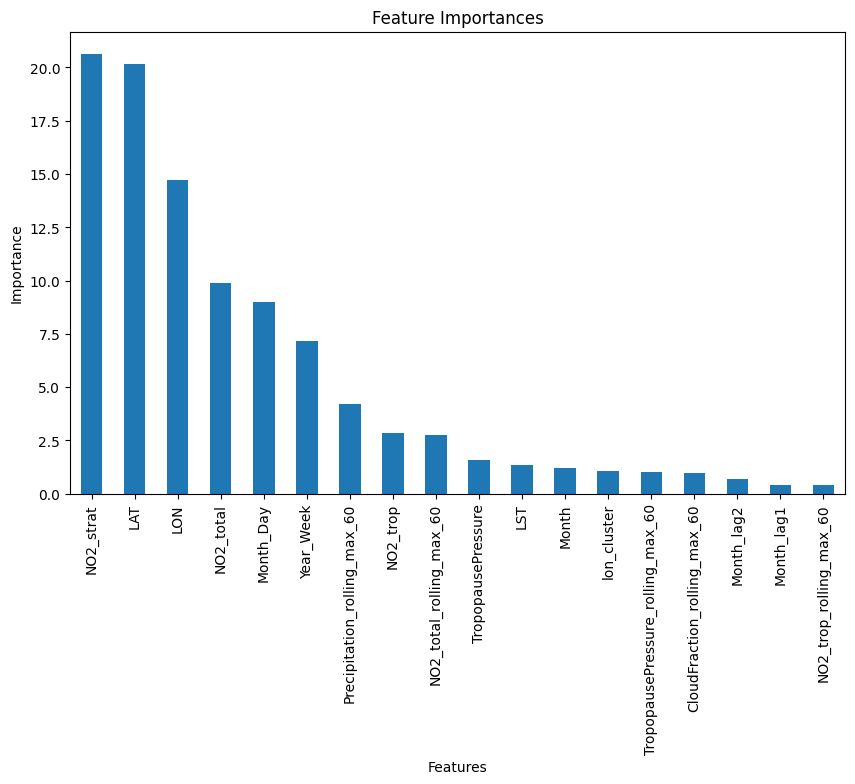

In [ ]:
importances = model.feature_importances_
names = model.feature_names_
fi = pd.DataFrame({'Feature': names,
                   'importances': importances})
fi = fi.sort_values(by='importances', ascending=False)

fi.plot(kind='bar', x='Feature', y='importances', legend=False, figsize=(10, 6))
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [ ]:
train.columns

Index(['LAT', 'LON', 'LST', 'NO2_strat', 'NO2_total', 'NO2_trop',
       'TropopausePressure', 'GT_NO2', 'lon_cluster', 'Month', 'Month_Day',
       'Year_Week', 'Month_lag1', 'Month_lag2', 'NO2_trop_rolling_max_60',
       'NO2_total_rolling_max_60', 'TropopausePressure_rolling_max_60',
       'CloudFraction_rolling_max_60', 'Precipitation_rolling_max_60'],
      dtype='object')